In [1]:
import urllib

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from PIL import Image
tf.compat.v1.enable_v2_behavior()

from rcnn_sat.rcnn_sat.preprocess import preprocess_image
from rcnn_sat.rcnn_sat.bl_net import bl_net

from data.generate_symmetry_images import make_random, make_images

In [2]:
data_path = "/om/user/shobhita/data/symmetry/rcnn_sat/"

In [4]:
train_data_synthetic = make_random(["NS0", "NS4", "S0", "S4"], n_images=4000)
pickle.dump(train_data_synthetic, open(data_path + "rcnn_train.pkl", "wb"))

datasets = ["NS0", "NS2", "NS4", "NS6", "NSd4", "S0", "S2", "S4", "S6", "Sd4"] + ["flank1S", "flank1NS", "flank2S", "flank2NS", "flank3S", "flank3NS"] + ['stripe2S', 'stripe4S', 'stripe6S', 'stripe8S', 'stripe10S', 'stripe2NS', 'stripe4NS', 'stripe6NS', 'stripe8NS', 'stripe10NS']

for ds in datasets:
    print(ds)
    test_set = make_images(ds, n_images=1e4)
    pickle.dump(test_set, open(data_path + "rcnn_{}_test.pkl".format(ds), "wb"))

NS0
NS2
NS4
NS6
NSd4
S0
S2
S4
S6
Sd4
flank1S
flank1NS
flank2S
flank2NS
flank3S
flank3NS
stripe2S
stripe4S
stripe6S
stripe8S
stripe10S
stripe2NS
stripe4NS
stripe6NS
stripe8NS
stripe10NS


In [5]:
input_layer = tf.keras.layers.Input((128, 128, 3))
model = bl_net(input_layer, classes=565, cumulative_readout=True)

In [6]:
_, msg = urllib.request.urlretrieve(
    'https://osf.io/9td5p/download', 'bl_imagenet.h5')
print(msg)

Server: nginx
Date: Wed, 21 Apr 2021 22:24:43 GMT
Content-Type: application/octet-stream
Content-Length: 112560228
X-Waterbutler-Request-Id: 1331e6ac-0061-477d-b1e3-4d85806ab130
Content-Disposition: attachment; filename="bl_ecoset.h5"; filename*=UTF-8''bl_ecoset.h5
Cache-Control: no-cache, no-store, max-age=0, must-revalidate
Expires: Mon, 01 Jan 1990 00:00:00 GMT
Pragma: no-cache
Via: 1.1 google
Alt-Svc: clear
Connection: close




In [7]:
model.load_weights('bl_imagenet.h5')

In [8]:
model.layers

In [14]:
model.layers[-17].name

'GlobalAvgPool_Time_7'

In [15]:
activation_fns = []
for ts in range(8):
    activation_fns.append(
        tf.keras.backend.function(
            [model.input],
            [model.get_layer('GlobalAvgPool_Time_{}'.format(ts)).output])
    )

In [16]:
train_data_synthetic = pickle.load(open(data_path + "rcnn_train.pkl", "rb"))
train_ims, train_labels = train_data_synthetic
train_ims, train_labels = train_ims[:10000], train_labels[:10000]

In [34]:
ims = train_ims[:4]
processed_ims = np.asarray([preprocess_image(np.asarray(Image.fromarray(x.astype("uint8")).convert("RGB").resize((128, 128)))) for x in ims])

In [42]:
batch_size = 2
activations = []
n_steps = len(processed_ims) // batch_size
for i in range(n_steps):
    batch_ims = processed_ims[i * batch_size : (i+1) * batch_size]
    batch_acts = []
    for ts in range(8):
        batch_act = activation_fns[ts](batch_ims)[0]
        batch_acts.append(batch_act)
    activations.append(np.concatenate(np.asarray(batch_acts), axis=1))
    

In [52]:
indices = np.random.choice(len(processed_ims), 2, replace=False)
processed_ims[indices].shape

(2, 128, 128, 3)

In [53]:
np.concatenate([processed_ims, processed_ims[indices]]).shape

(6, 128, 128, 3)

In [24]:
act = activation_fns[0](processed_ims)[0]

In [27]:
def get_activations(ims):
    processed_ims = np.asarray([preprocess_image(np.asarray(Image.fromarray(x.astype("uint8")).convert("RGB").resize((128, 128)))) for x in ims])
    
    activations = []
    for ts in range(3):
        print(ts)
        act = activation_fns[ts](processed_ims)[0]
        activations.append(act)
        
    return np.concatenate(np.asarray(activations), axis=1)

In [32]:
trainx = get_activations(train_ims[:4])
trainy = train_labels[:4]

0
1
2


In [29]:
trainx.shape

(4, 6144)

In [92]:
from sklearn.linear_model import LogisticRegression

In [93]:
model = LogisticRegression()
model_fit = model.fit(trainx, trainy)

In [99]:
testx = get_activations(train_ims[4:6])
testy = train_labels[4:6]
pred = model_fit.predict_proba(testx)

0
1
2


In [100]:
pred

array([[0.26089919, 0.73910081],
       [0.96401262, 0.03598738]])

In [105]:
preds = np.argmax(pred, axis=1)
np.sum(preds == testy) / len(testy)

0.5

In [112]:
test_sets = ["NS0", "NS2", "NS4", "NS6", "NSd4", "S0", "S2", "S4", "S6", "Sd4"] + ["flank1S", "flank1NS", "flank2S", "flank2NS", "flank3S", "flank3NS"] + ['stripe2S', 'stripe4S', 'stripe6S', 'stripe8S', 'stripe10S', 'stripe2NS', 'stripe4NS', 'stripe6NS', 'stripe8NS', 'stripe10NS']
for ds in test_sets[:2]:
    test_ims, test_labels = pickle.load(open(data_path + "rcnn_{}_test.pkl".format(ds), "rb"))

In [114]:
len(test_ims)

10000

In [121]:
path = "/om/user/shobhita/data/symmetry/natural_images/"

with open(path + "symm_testing.pkl", "rb") as handle:
    full_test = np.asarray(pickle.load(handle))


In [123]:
subset = full_test[np.random.randint(len(full_test), size=500), :]

1


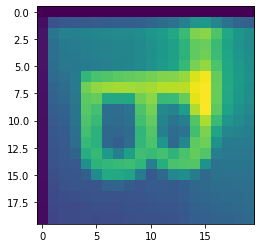

In [133]:
idx=12
plt.imshow(subset[idx][0])
print(subset[idx][1])